# Data Forecasting

The module is in charge of: 
- forecasting the value of temperature in the next X seconds; 
- forecasting the value of humidity in the next X seconds; 
- forecasting the value of the gas sensor in the next X seconds 

(X is defined by users or developers). 

The time-series of the predicted values must be saved on INFLUX and shown on the GRAFANA dashboard as well; e.g. by using two lines for the temperature graph, one related to raw measurements, one to predictions. One or multiple techniques for time-series forecasting can be developed and compared.


## Import Dependencies

In [ ]:
!pip3 install influxdb_client
!pip3 install statsmodels
!pip3 install sklearn
!pip3 install cufflinks
!pip3 install pmdarima
!pip3 install chart-studio

In [1]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import numpy as np
import pandas as pd
import seaborn as sns
import random
from datetime import datetime,timezone
import dateutil.parser
import time
import statsmodels.graphics.tsaplots as tsaplots
from datetime import timedelta
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.write_api import WriteType

## Influx Setting

In [55]:
INFLUXDB_HOST = os.getenv("INFLUX_HOST")
INFLUXDB_PORT = os.getenv("INFLUX_HOST_PORT")
INFLUXDB_ORG = os.getenv("INFLUX_ORG")
INFLUXDB_TOKEN = os.getenv("INFLUX_TOKEN")
client = InfluxDBClient(url="http://"+INFLUXDB_HOST+":"+INFLUXDB_PORT, token=INFLUXDB_TOKEN, org=INFLUXDB_ORG)

### Influx Queries

[<FluxTable: 12 columns, 350 records>]
[<FluxTable: 12 columns, 350 records>]
[<FluxTable: 12 columns, 350 records>]


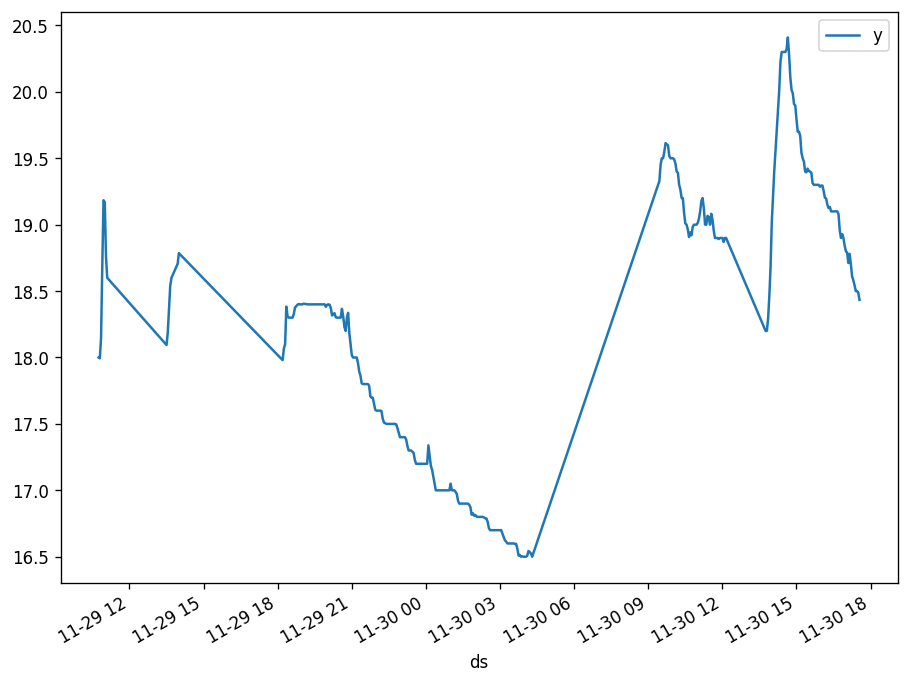

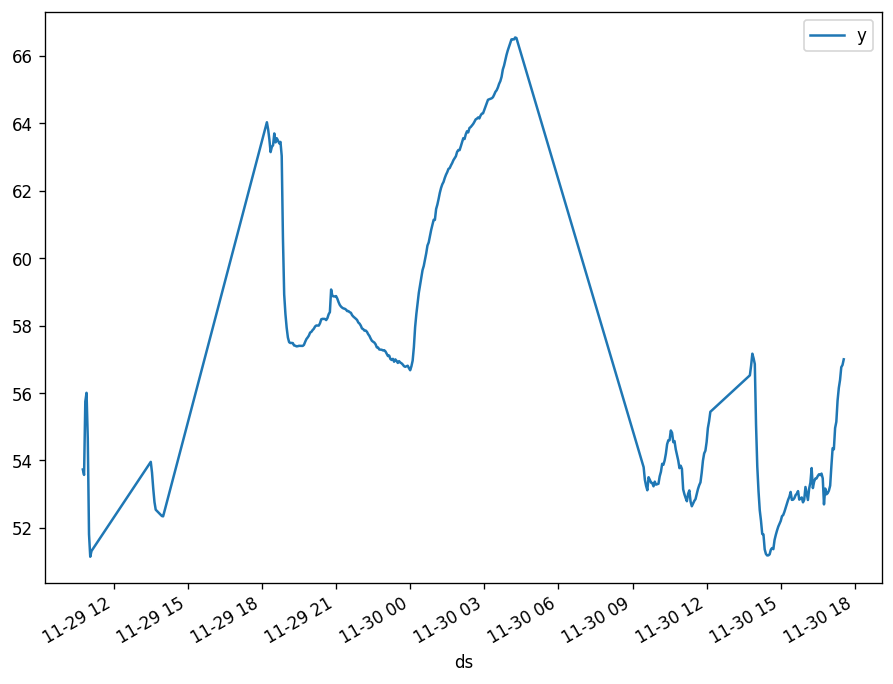

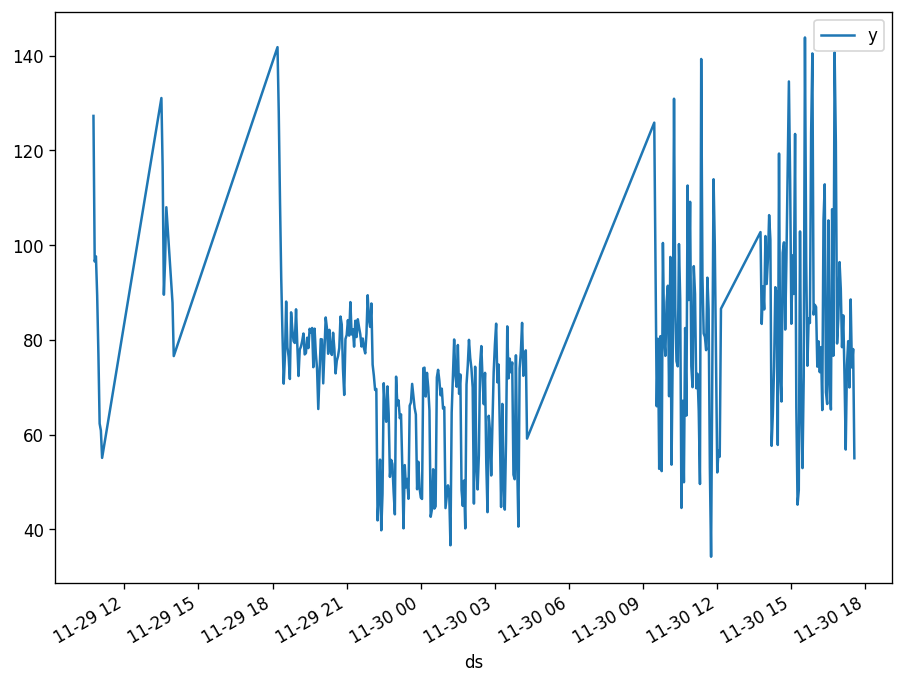

In [57]:
from pandas import DataFrame


def result_to_dataframe(result):
    raw = []
    for table in result:
        for record in table.records:
            raw.append((record.get_time(), record.get_value()))
    return pd.DataFrame(raw, columns=['ds','y'], index=None)
    
buckets = ['temperature', 'humidity', 'gas']
dfTemp = DataFrame
dfHum = DataFrame
dfGas = DataFrame

for bucket in buckets:
    query = 'from(bucket: "' + bucket + '")' \
                ' |> range(start: 2022-11-29T01:00:00.00Z, stop: 2022-11-30T23:00:00.00Z)' \
                ' |> filter(fn: (r) => r["_measurement"] == "val")' \
                ' |> filter(fn: (r) => r["_field"] == "'+ bucket + '")' \
                ' |> aggregateWindow(every: 3m, fn: mean, createEmpty: false)'\
                ' |> yield(name: "mean")'\

    result = client.query_api().query(org=INFLUXDB_ORG, query=query)
    print(result)
    # Convert the results to dataframe
    if (bucket == "temperature" and  result):
        dfTemp = result_to_dataframe(result)
        dfTemp['ds'] = dfTemp['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfTemp[plot_cols]
        plot_features.index = dfTemp['ds']
        _ = plot_features.plot(subplots=True)

    if (bucket == "humidity" and result):
        dfHum = result_to_dataframe(result)
        dfHum['ds'] = dfHum['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfHum[plot_cols]
        plot_features.index = dfHum['ds']
        _ = plot_features.plot(subplots=True)

    if (bucket == "gas" and result):
        dfGas = result_to_dataframe(result)
        dfGas['ds'] = dfGas['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfGas[plot_cols]
        plot_features.index = dfGas['ds']
        _ = plot_features.plot(subplots=True)

### Informations about DataFrames. Train and Test Datasets cretion 

In [59]:
trainTemp = DataFrame
testTemp = DataFrame
trainHum= DataFrame
testHum = DataFrame
trainGas = DataFrame
testGas = DataFrame
global tempDate
global humDate
global gasDate

if ( not dfTemp.empty):
    print("Temperature Dataset")    
    print(dfTemp.describe().transpose())
    nrows = (len(dfTemp.values))
    splitPoint = int (nrows * 0.80)
    trainTemp = dfTemp['y'] [:splitPoint]
    testTemp = dfTemp ['y'] [splitPoint:]
    tempDate = dfTemp ['ds'] [splitPoint:].to_frame().reset_index()
    # truncate ds to minutes
    tempDate['ds'] = tempDate.ds.dt.floor('min')

if (not dfHum.empty):
    print("Humidity Dataset")
    print(dfHum.describe().transpose())
    nrows = (len(dfHum.values))
    splitPoint = int (nrows * 0.80)
    trainHum = dfHum['y'] [:splitPoint]
    testHum = dfHum ['y'] [splitPoint:]
    humDate = dfHum ['ds'] [splitPoint:].to_frame().reset_index()
    # truncate ds to minutes
    humDate['ds'] = humDate.ds.dt.floor('min')   

if (not dfGas.empty):
    print("Gas Dataset")
    print(dfGas.describe().transpose())
    nrows = (len(dfGas.values))
    splitPoint = int (nrows * 0.80)
    trainGas = dfGas['y'] [:splitPoint]
    testGas = dfGas ['y'] [splitPoint:]
    gasDate = dfGas ['ds'] [splitPoint:].to_frame().reset_index()
    # truncate ds to minutes
    humDate['ds'] = humDate.ds.dt.floor('min')

Temperature Dataset
   count       mean       std   min   25%        50%        75%        max
y  350.0  18.166502  1.035948  16.5  17.2  18.320833  19.011648  20.409375
Humidity Dataset
   count       mean     std        min        25%        50%        75%  \
y  350.0  57.478708  4.2342  51.144944  53.477778  57.320714  60.098333   

         max  
y  66.544444  
Gas Dataset
   count       mean        std   min        25%        50%        75%  \
y  350.0  75.945217  19.936691  34.2  65.194444  75.361111  83.915995   

         max  
y  143.84375  


### Finding the value of the d parameter 

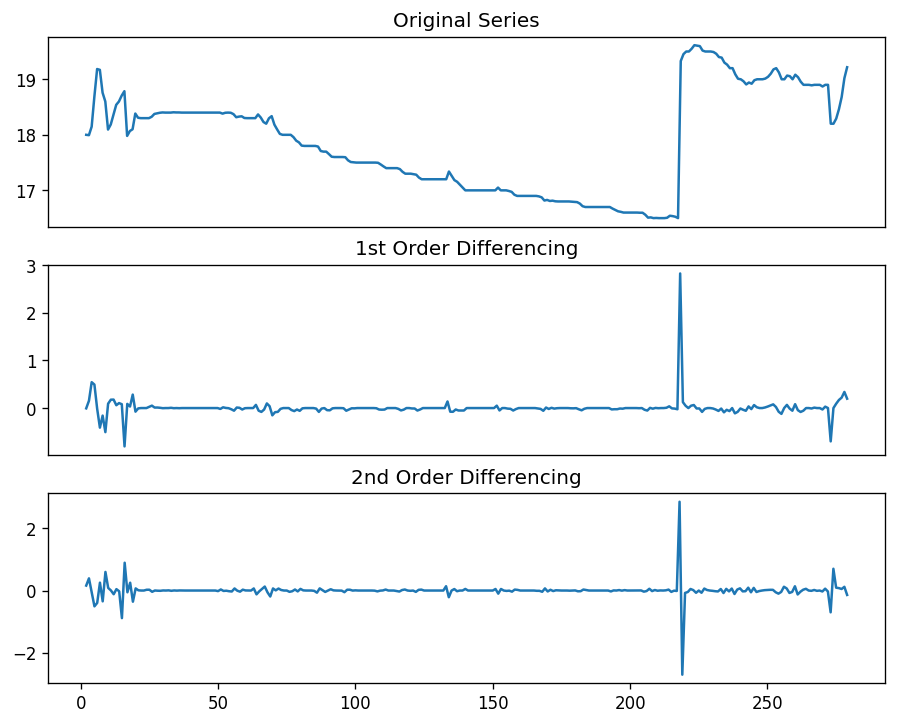

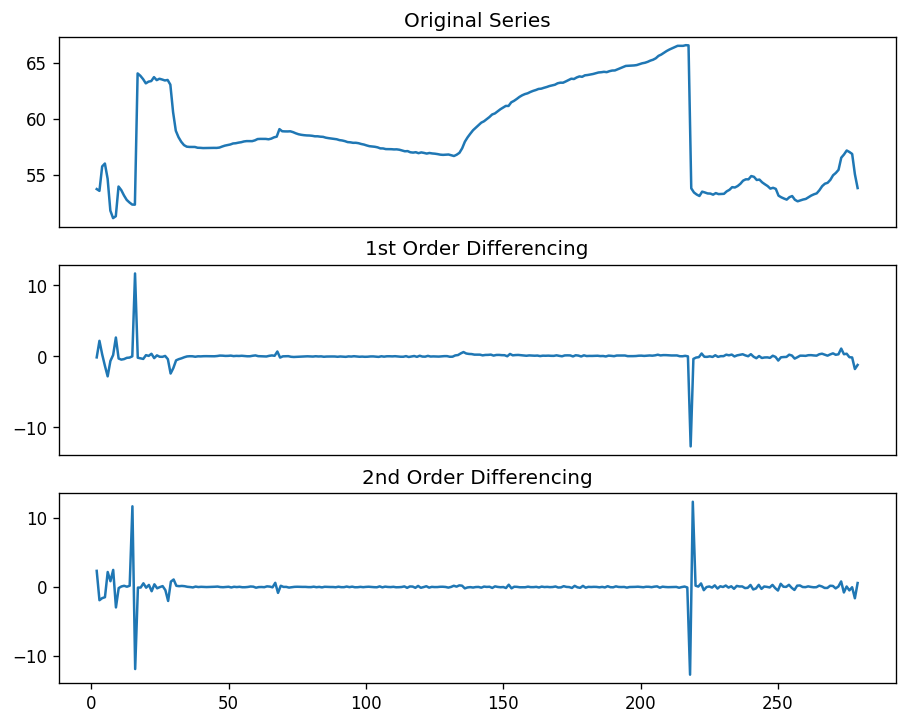

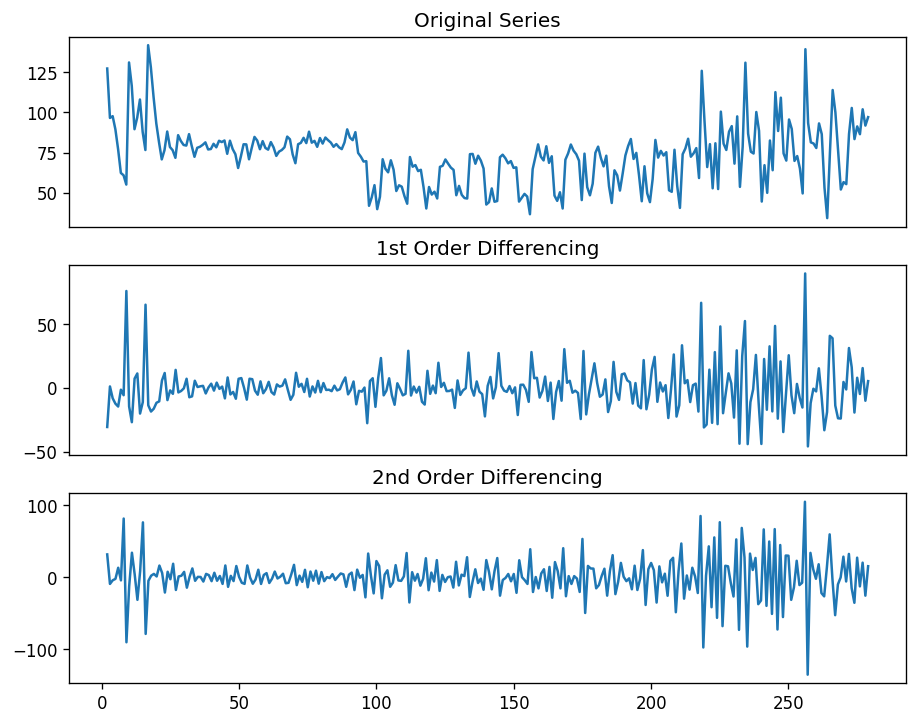

In [60]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
def printPlot(dataset):
    plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
    # Original Series
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    ax1.plot(dataset); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
    # 1st Differencing
    ax2.plot(dataset.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
    # 2nd Differencing
    ax3.plot(dataset.diff().diff()); ax3.set_title('2nd Order Differencing')
    plt.show()

if ( not dfTemp.empty):
    printPlot(trainTemp)

if (not dfHum.empty):
    printPlot(trainHum)   

if (not dfGas.empty):
    printPlot(trainGas)

### Check if the time-series are stationary using the Dickey-Fuller test

In [61]:
from statsmodels.tsa.stattools import adfuller

resultTemp = 0.0
resultHum = 0.0
resultGas = 0.0

if (not dfTemp.empty):
    resultTemp = adfuller(trainTemp)
    print('TEMPERATURE: ADF Statistic: %f' % resultTemp[0])
    print('TEMPERATURE: p-value: %f' % resultTemp[1])

if (not dfHum.empty):
    resultHum = adfuller(trainHum)
    print('HUMIDITY: ADF Statistic: %f' % resultHum[0])
    print('HUMIDITY: p-value: %f' % resultHum[1])

if (not dfGas.empty):
    resultGas = adfuller(trainGas)
    print('GAS: ADF Statistic: %f' % resultGas[0])
    print('GAS: p-value: %f' % resultGas[1])
    

TEMPERATURE: ADF Statistic: -1.518430
TEMPERATURE: p-value: 0.524375
HUMIDITY: ADF Statistic: -2.515790
HUMIDITY: p-value: 0.111679
GAS: ADF Statistic: -2.012761
GAS: p-value: 0.281006


### If P Value > 0.05 we go ahead with finding the order of differencing.

TEMPERATURE: ADF Statistic: -15.202207
TEMPERATURE: new p-value: 0.000000


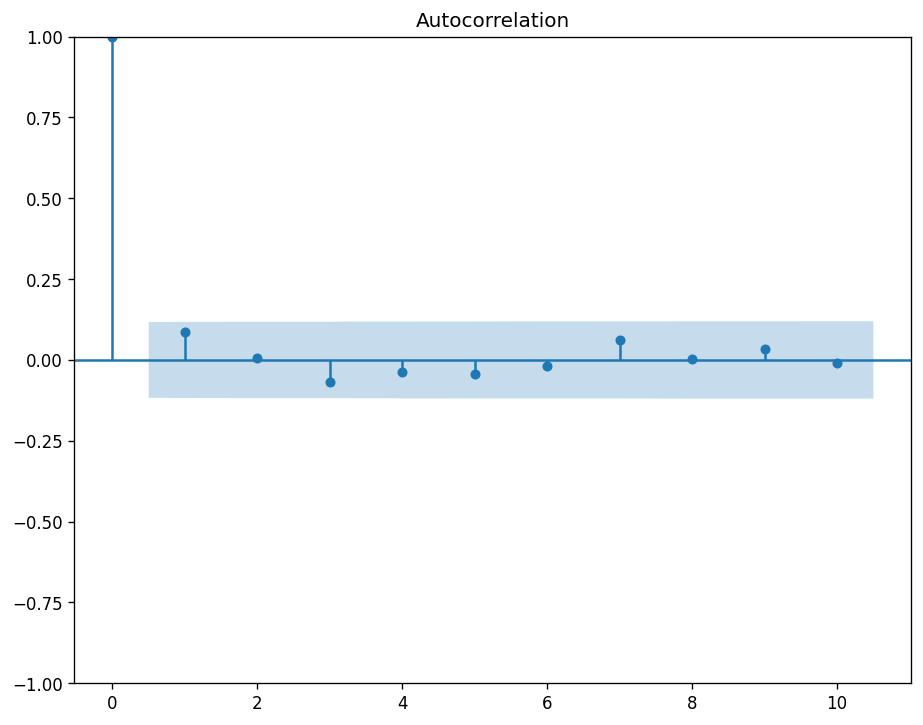

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



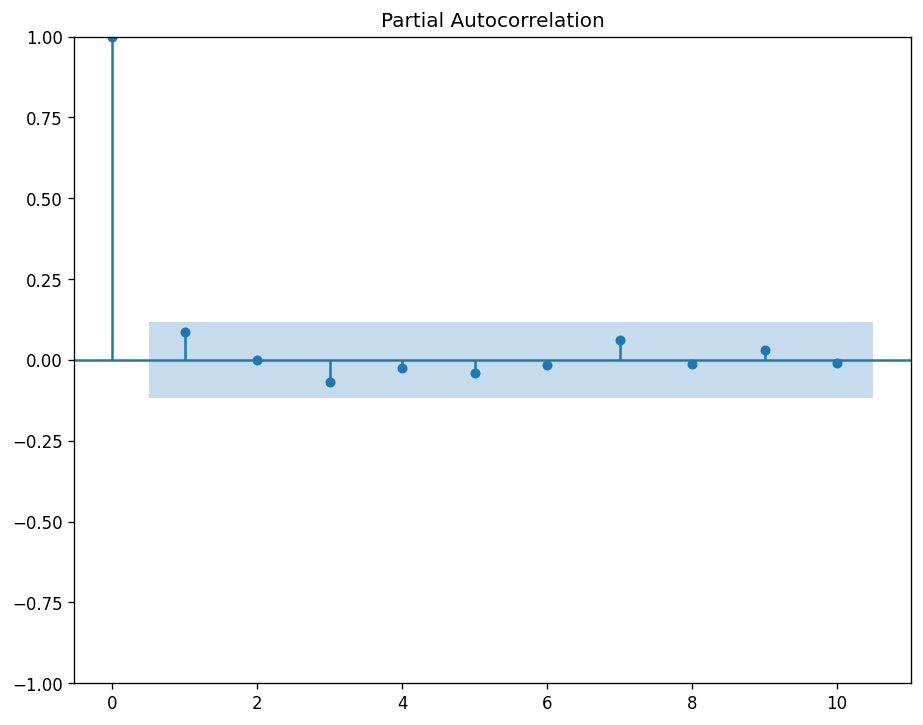

HUMIDITY: ADF Statistic: -15.617764
HUMIDITY: new p-value: 0.000000


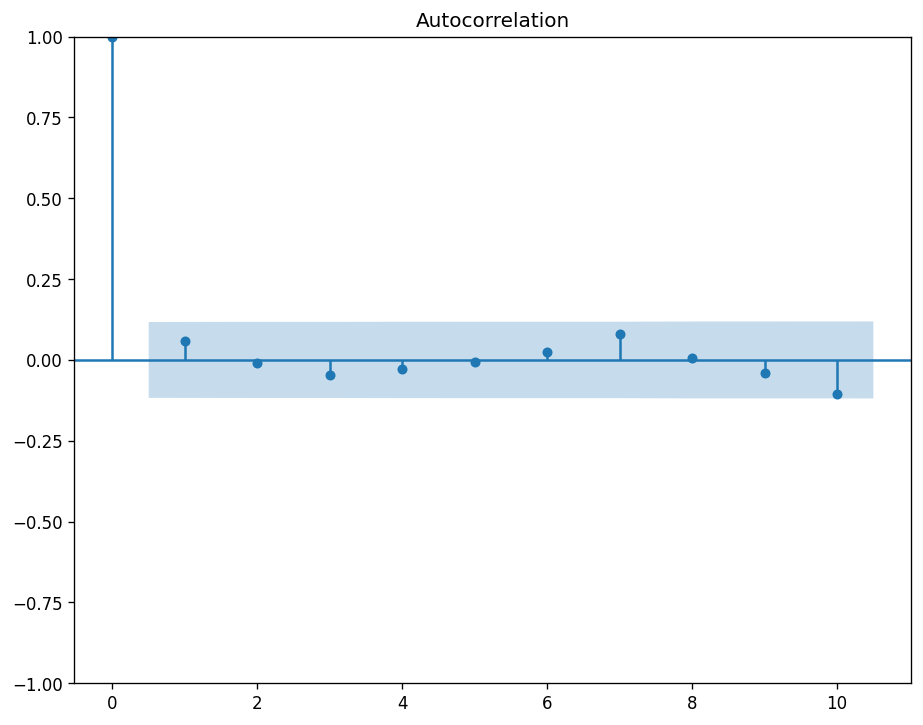

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



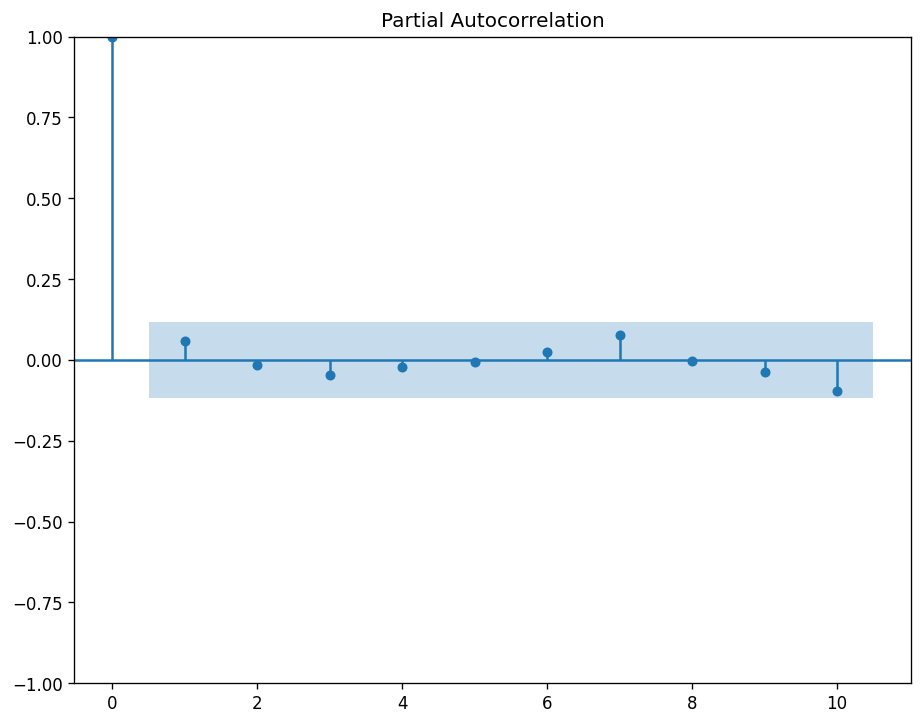

GAS: ADF Statistic: -10.857407
GAS: new p-value: 0.000000


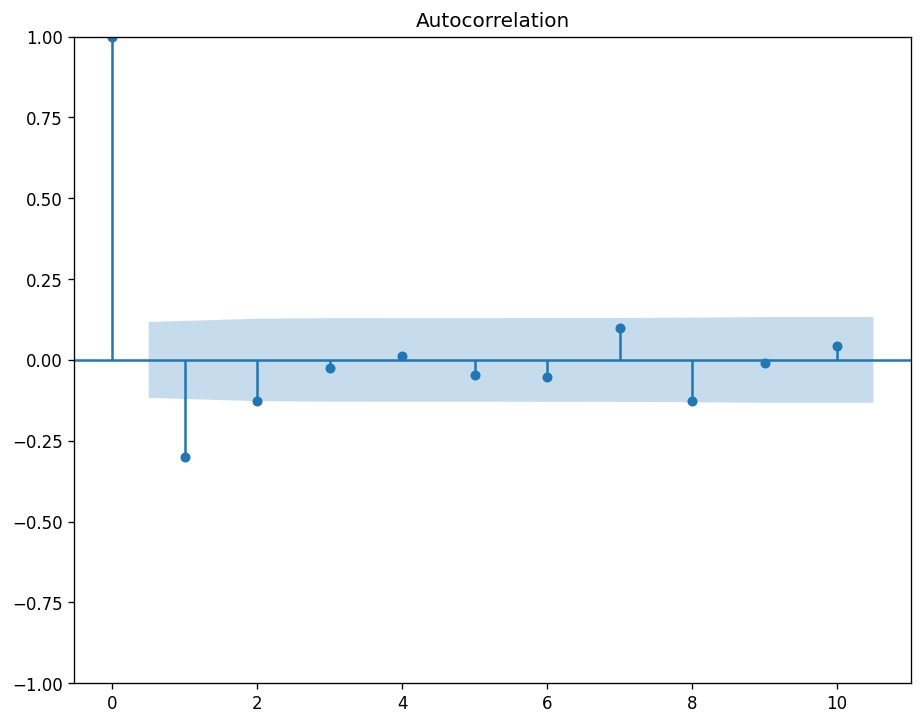

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



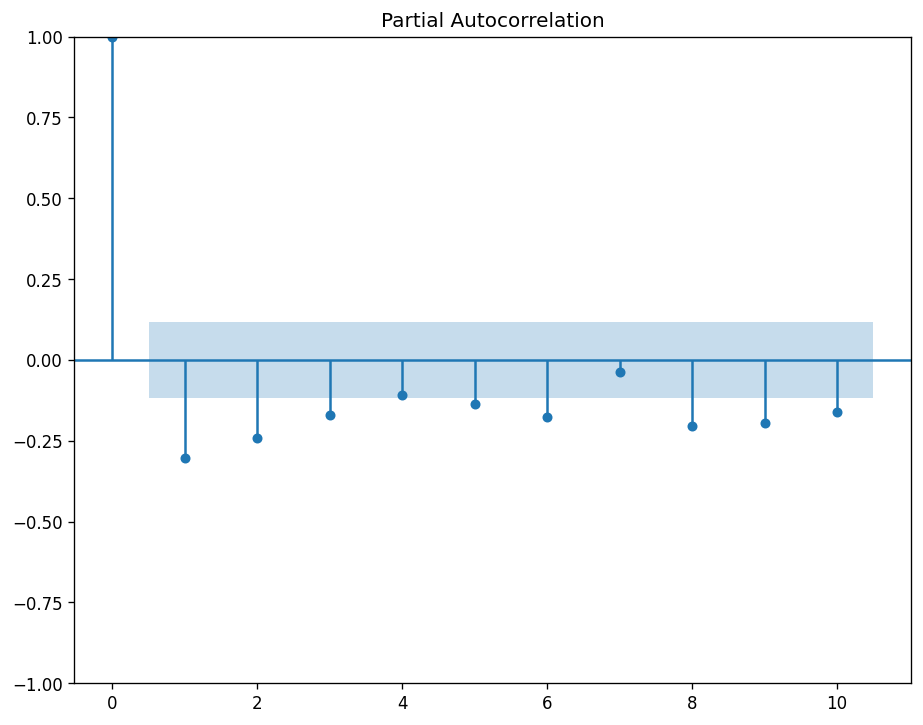

In [62]:
from statsmodels.graphics import tsaplots

if (not dfTemp.empty):
    aux = trainTemp
    train_new = aux.diff().dropna()
    result = adfuller(train_new)
    print('TEMPERATURE: ADF Statistic: %f' % result[0])
    print('TEMPERATURE: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

if (not dfHum.empty):
    aux = trainHum
    train_new = aux.diff().dropna()
    result = adfuller(train_new)
    print('HUMIDITY: ADF Statistic: %f' % result[0])
    print('HUMIDITY: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

if (not dfGas.empty):
    aux = trainGas
    train_new = aux.diff().dropna()
    result = adfuller(train_new)
    print('GAS: ADF Statistic: %f' % result[0])
    print('GAS: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

### Apply ARIMA model to all Datasets

In [63]:
from statsmodels.tsa.arima.model import ARIMA
import math
from sklearn.metrics import mean_squared_error
#ARIMA(p,d,q)

global temp_model_fit
global hum_model_fit
global gas_model_fit

if (not trainTemp.empty):
  historyTemp = [x for x in trainTemp]
  predictionsTemp = list()
if (not trainHum.empty):
  historyHum = [x for x in trainHum]
  predictionsHum = list()
if (not trainGas.empty):
  historyGas= [x for x in trainGas]
  predictionsGas = list()

if (not dfTemp.empty):
  for t in testTemp.index:
    model = ARIMA(historyTemp, order=(0,1,0))
    temp_model_fit = model.fit()
    output = temp_model_fit.forecast()
    yest = output[0]
    predictionsTemp.append(yest)
    obs= testTemp[t]
    historyTemp.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))

if (not dfHum.empty):
  for t in testHum.index:
    model = ARIMA(historyHum, order=(0,1,0))
    hum_model_fit = model.fit()
    output = hum_model_fit.forecast()
    yest = output[0]
    predictionsHum.append(yest)
    obs= testHum[t]
    historyHum.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))

if (not dfGas.empty):
  for t in testGas.index:
    model = ARIMA(historyGas, order=(1,1,1))
    gas_model_fit = model.fit()
    output = gas_model_fit.forecast()
    yest = output[0]
    predictionsGas.append(yest)
    obs= testGas[t]
    historyGas.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))


predicted=19.216667, expected=19.405556
predicted=19.405556, expected=19.558333
predicted=19.558333, expected=19.702778
predicted=19.702778, expected=19.867857
predicted=19.867857, expected=20.011111
predicted=20.011111, expected=20.225000
predicted=20.225000, expected=20.300000
predicted=20.300000, expected=20.300000
predicted=20.300000, expected=20.300000
predicted=20.300000, expected=20.300000
predicted=20.300000, expected=20.322222
predicted=20.322222, expected=20.409375
predicted=20.409375, expected=20.280556
predicted=20.280556, expected=20.108333
predicted=20.108333, expected=20.013889
predicted=20.013889, expected=19.988889
predicted=19.988889, expected=19.908333
predicted=19.908333, expected=19.897222
predicted=19.897222, expected=19.791667
predicted=19.791667, expected=19.700000
predicted=19.700000, expected=19.700000
predicted=19.700000, expected=19.669444
predicted=19.669444, expected=19.541667
predicted=19.541667, expected=19.500000


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=19.500000, expected=19.475000
predicted=19.475000, expected=19.400000
predicted=19.400000, expected=19.394444
predicted=19.394444, expected=19.422222
predicted=19.422222, expected=19.402857
predicted=19.402857, expected=19.400000
predicted=19.400000, expected=19.391667
predicted=19.391667, expected=19.313889
predicted=19.313889, expected=19.300000
predicted=19.300000, expected=19.300000
predicted=19.300000, expected=19.300000
predicted=19.300000, expected=19.300000
predicted=19.300000, expected=19.300000
predicted=19.300000, expected=19.285714
predicted=19.285714, expected=19.294444
predicted=19.294444, expected=19.294444
predicted=19.294444, expected=19.252778
predicted=19.252778, expected=19.202778
predicted=19.202778, expected=19.197222
predicted=19.197222, expected=19.150000
predicted=19.150000, expected=19.125000
predicted=19.125000, expected=19.133333
predicted=19.133333, expected=19.100000
predicted=19.100000, expected=19.100000
predicted=19.100000, expected=19.100000


In [64]:
def send_predictions(df, date, bucket):
	lines = [str(df['y'][d]) for d in range(len(df))]
	if(bucket == "gas"):
		lines = ['val,prediction=yes,clientId=' + str("diubi-esp-32")+",lat=999,lng=999"+ " gasPred" + '=' + str(df['y'][d])
										+ ' ' + str(int(time.mktime(date['ds'][d].timetuple()))) + "000000000" for d in range(len(date))]
	else:
		lines = ['val,prediction=yes,clientId=' + str("diubi-esp-32")+",lat=999,lng=999"+ " " + bucket + '=' + str(df['y'][d])
										+ ' ' + str(int(time.mktime(date['ds'][d].timetuple()))) + "000000000" for d in range(len(date))]
	write_client = client.write_api(write_options=WriteOptions(batch_size=1000, flush_interval=10_000,
															jitter_interval=2_000, retry_interval=5_000, write_type=WriteType.synchronous))
	write_client.write(bucket, INFLUXDB_ORG, lines)

### ARIMA model evaluation (RMSE)

Test RMSE: 0.073


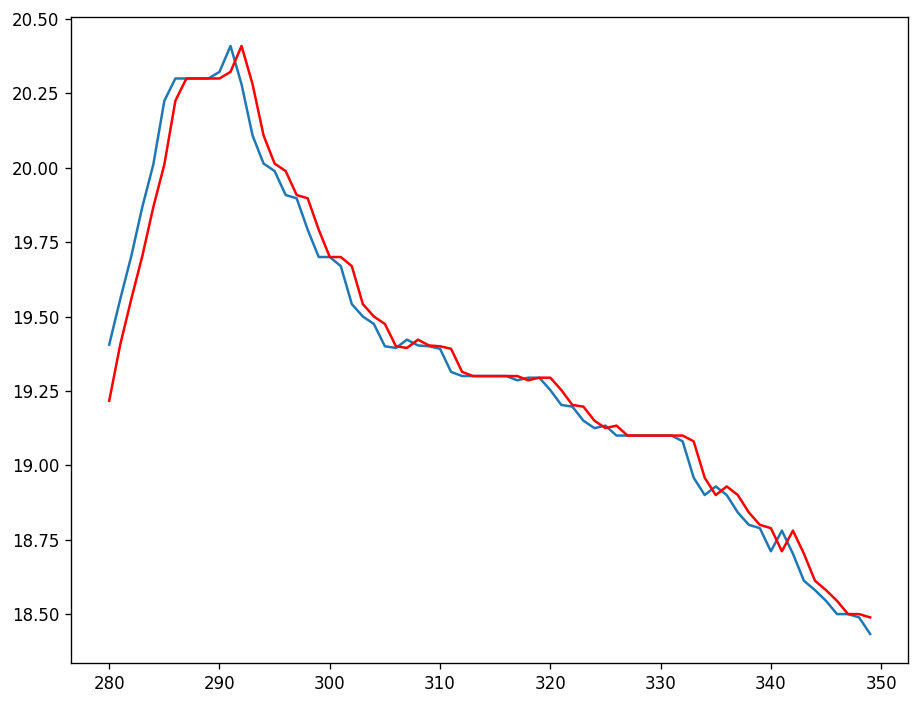

Test RMSE: 0.278


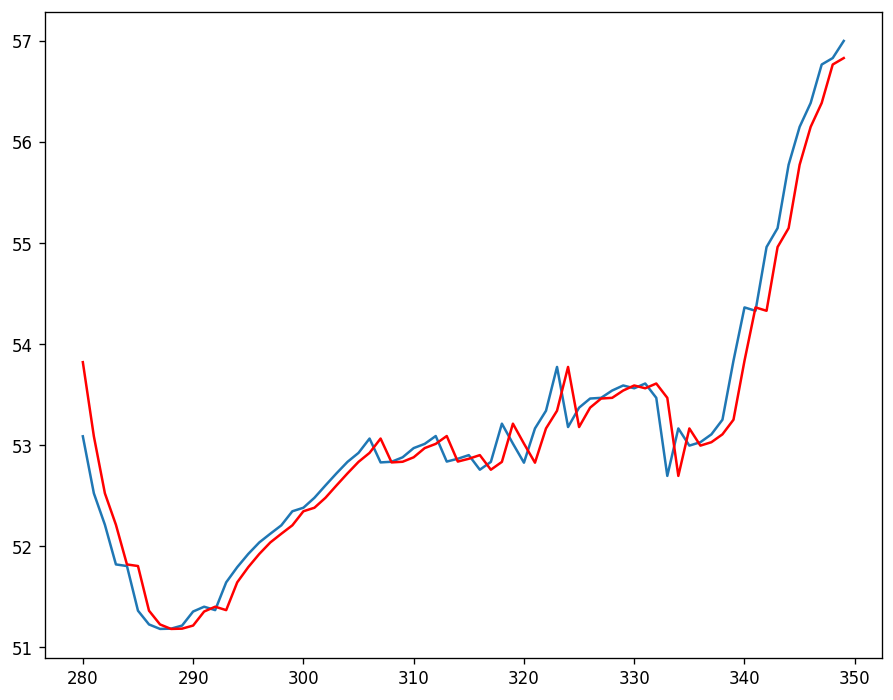

Test RMSE: 22.640


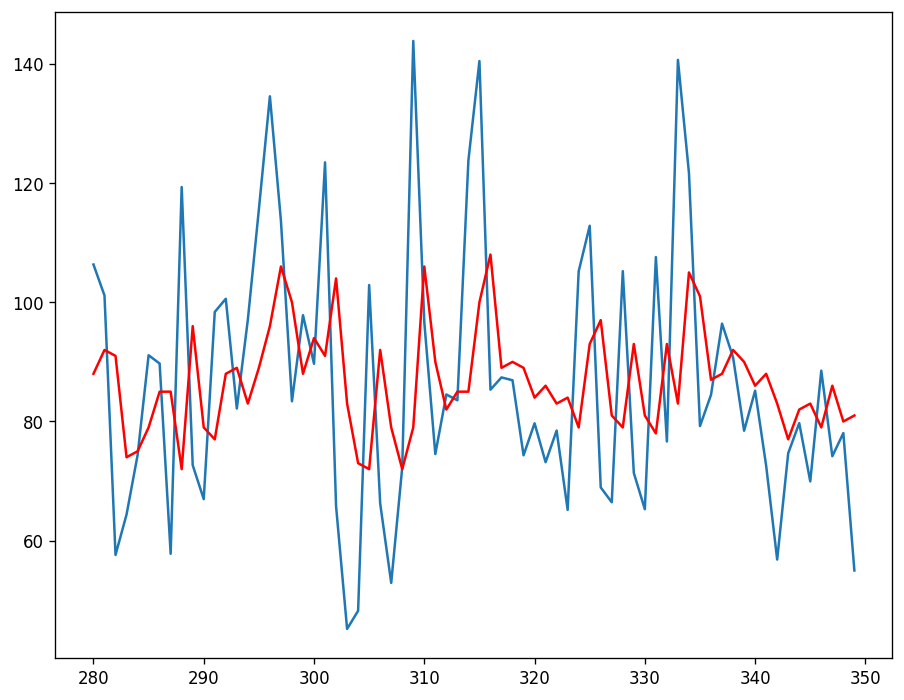

In [65]:
if (not trainTemp.empty):
  rmse = math.sqrt(mean_squared_error(testTemp, predictionsTemp))
  print('Test RMSE: %.3f'% rmse)
  df = pd.DataFrame(predictionsTemp)
  df.columns = ['y']
  send_predictions(df, tempDate, "temperature")
  df.set_index(testTemp.index, inplace=True)
  plt.plot(testTemp)
  plt.plot(df, color='red')
  plt.show()

if (not trainHum.empty):
  rmse = math.sqrt(mean_squared_error(testHum, predictionsHum))
  print('Test RMSE: %.3f'% rmse)
  df = pd.DataFrame(predictionsHum)
  df.columns = ['y']
  send_predictions(df, humDate, "humidity")
  df.set_index(testHum.index, inplace=True)
  plt.plot(testHum)
  plt.plot(df, color='red')
  plt.show()
  
if (not trainGas.empty):
  rmse = math.sqrt(mean_squared_error(testGas, predictionsGas))
  print('Test RMSE: %.3f'% rmse)
  df = pd.DataFrame(predictionsGas)
  df.columns = ['y']
  df["y"] = df["y"].astype(int)
  send_predictions(df, gasDate, "gas")
  df.set_index(testGas.index, inplace=True)
  plt.plot(testGas)
  plt.plot(df, color='red')
  plt.show()

### Evaluation

In [66]:
#Temperature evaluation
temp_forecast = temp_model_fit.get_forecast()
temp_forecast.summary_frame()
yhat = temp_forecast.predicted_mean
yhat_conf_int = temp_forecast.conf_int(alpha=0.05)

print('Temperature Model Evaluation Summary:')
print('-'*40)
print('Mean: {}'.format(yhat))
print('Confidence Interval: {}'.format(yhat_conf_int))

#Temperature evaluation
hum_forecast = hum_model_fit.get_forecast()
hum_forecast.summary_frame()
yhat = hum_forecast.predicted_mean
yhat_conf_int = hum_forecast.conf_int(alpha=0.05)

print('Humidity Model Evaluation Summary:')
print('-'*40)
print('Mean: {}'.format(yhat))
print('Confidence Interval: {}'.format(yhat_conf_int))

#Temperature evaluation
gas_forecast = gas_model_fit.get_forecast()
gas_forecast.summary_frame()
yhat = gas_forecast.predicted_mean
yhat_conf_int = gas_forecast.conf_int(alpha=0.05)

print('Gas Model Evaluation Summary:')
print('-'*40)
print('Mean: {}'.format(yhat))
print('Confidence Interval: {}'.format(yhat_conf_int))



Temperature Model Evaluation Summary:
----------------------------------------
Mean: [18.48888889]
Confidence Interval: [[18.13639388 18.84138389]]
Humidity Model Evaluation Summary:
----------------------------------------
Mean: [56.83055556]
Confidence Interval: [[54.8705009  58.79061021]]
Gas Model Evaluation Summary:
----------------------------------------
Mean: [81.95930984]
Confidence Interval: [[ 49.28307731 114.63554237]]
